<html>
<div>
  <span style="font-family: Poppins; font-size:30px; color: black;"> <br/> University of Tehran <br/>
</div>
<span style="font-family: Poppins; font-size:15pt; color: black; vertical-align: middle;"> Mobina Mehrazar </span><br>
<span style="font-family: Poppins; font-size:15pt; color: black; vertical-align: middle;"> 810100216 </span>

</html>

# Introduction

In this project, our objective is to analyze and categorize news articles from the Analytical News of Asre Iran website using clustering algorithms.

By leveraging these algorithms, we aim to delve into the dataset and systematically classify the news into different clusters.

The goal is to ensure that, post-application of clustering algorithms, articles are grouped together in their respective clusters as accurately as possible.

----

***1.*** 
If the data was imbalanced, what challenges would arise in the clustering process? What solution do you propose to address this issue? Explain.

In the case of **imbalanced data**, clustering may face challenges because the model could be biased towards the majority class, leading to **poor perfornamce**.
As ML models are often designed to optimize for overall accuracy, which can result in the model being biased towards the majority class.

1. **Resampling:**<br>
To address this issue, one solution is to employ techniques such as **oversampling**, **undersampling**, or using more advanced methods like **Synthetic Minority Over-sampling Technique** (**SMOTE**).<br><br>
These methods help balance the class distribution by:<br>
`oversampling` : replicating instances from minority classes.<br>
`undersampling` : removing instances from the majority class.<br> 
`SMOTE` :  generagtes synthetic instances from minority classes to overcome the imbalance problem.<br>
Chosing the appropriate method depends on the characteristics of the dataset and the specific requirements of the problem at hand.<br>
Balancing the dataset enhances the model's ability to learn patterns from all classes and improve its overall performance, especially on minority classes.

2. **Cost-Sensitive Learning**:<br>
In this method, a greater misclassification cost is attributed to the minority class, aiming to encourage the model to focus more on learning and accurately classifying instances belonging to the minority class.

3. **Data-level and Hybrid Methods**:<br> 
These methods involve manipulating the data to create a more balanced dataset.

4. **Class Decomposition**:<br> 
This method involves detecting and removing negative instances from the overlapping region using neighborhood searching techniques.

----

In [1]:
import pandas as pd
# import hazm as hzm
from hazm import *
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import multiprocessing
from sklearn import utils
import matplotlib.pyplot as plt
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import ParameterGrid

# Phase one: Data preprocessing

In [2]:
FILE_PATHS = {
    "train": "dataset/train.csv",
    "test": "dataset/test.csv"
}

In [3]:
train_df = pd.read_csv(FILE_PATHS["train"])
test_df = pd.read_csv(FILE_PATHS["test"])

In [4]:
train_df.head(100)

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
...,...,...
95,ورزشی,تارنمای خبری «فاکس اسپورتس آسیا» در گزارشی به ...
96,حوادث,راننده سوناتا که حدود یک ماه قبل در جریان درگی...
97,حوادث,مصدومان حادثه واژگونی اتوبوس در محور سوادکوه پ...
98,سیاسی,فرمانده پاسداران انقلاب اسلامی گفت: نیروهای مس...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    9000 non-null   object
 1   content  9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [6]:
train_df.describe()

,label,content
count,9000,9000
unique,6,8980
top,فناوری,منبع: ایسنا
freq,1500,4


In [7]:
print(f"Label counts in training data: ")
train_df['label'].value_counts()

Label counts in training data: 


label
فناوری         1500
ورزشی          1500
حوادث          1500
سلامت          1500
سیاسی          1500
فرهنگی/هنری    1500
Name: count, dtype: int64

In [8]:
test_df.describe()

,label,content
count,1115,1115
unique,6,1113
top,حوادث,عصرخبر
freq,200,3


In [9]:
print(f"Label counts in testing data: ")
test_df['label'].value_counts()

Label counts in testing data: 


label
حوادث          200
سیاسی          200
ورزشی          190
فرهنگی/هنری    180
سلامت          177
فناوری         168
Name: count, dtype: int64

----

***2.*** 
Explain the replacement of words using the stemming or lemmatization method.



One of the key features of the module is the differentiation between a Lemmatizer and a Stemmer. The fundamental distinction lies in their approaches to understanding the meaning of words and extracting their roots.

- `Stemmer`:<br> This function operates **without a comprehensive understanding of a word's meaning**. It attempts to find the root of a word by simply **removing certain suffixes**. While efficient, it may occasionally yield inaccurate results in root extraction for certain words.

- `Lemmatizer`:<br> In contrast, the Lemmatizer performs **root extraction** based on a curated list of reference words along with their corresponding roots. This method provides more precise results, offering a deeper understanding of the language. However, this increased accuracy comes at the cost of **slower processing speed**.

---

The preprocessing function is designed to improve the quality of our textual data prior to the application of clustering algorithms. <br><br>
It involves three primary steps:

- `Normalization`: <br>
Employing a custom normalizer, each document undergoes a process to ensure consistent formatting and minimize noise.

- `Tokenization`: <br>
The normalized text is then tokenized using the word_tokenize function from the Hazm library, **breaking it down into individual words**.

- `Lemmatization and Stemming`: <br>
Subsequently, each token undergoes lemmatization and stemming. Lemmatization reduces words to their base or root form, while stemming simplifies words by removing prefixes or suffixes. These procedures contribute to a more focused and concise representation of the text.

----

***3.*** Explain the rationale for using a feature vector and its features in the report.

A feature vector is a **numerical representation** of an object or data point in a dataset.<br><br>
Each element in the feature vector corresponds to a specific feature or attribute of the object, and the combination of these elements forms a vector that describes the object in a multi-dimensional space.<br> 
Feature vectors play a crucial role in various tasks, such as **classification**, **regression**, and **clustering**.<br>
The feature vectors are likely being used to represent documents for some downstream machine learning task, leveraging a model's ability to infer numerical representations from the words in the documents.

Reasons for Using Feature Vectors:<br><br>
- `Numerical Representation`:<br>
Feature vectors convert textual or categorical data into numerical form, which is essential for many machine learning algorithms, which typically operate on numerical data.<br>
- `Fixed Length`:<br>
Feature vectors typically have a fixed length, where each element corresponds to a specific feature. This ensures consistency in the representation of data points.<br>
- `Numerical Values`:<br>
Elements of the feature vector are numerical values, allowing mathematical operations and comparisons to be performed on them.<br>
- `Sparsity:` <br>
Text data is often sparse (many zero values), and feature vectors can efficiently represent this sparsity.<br>
- `Dimensionality`:<br>
They help in dealing with the high-dimensional nature of text data. Each dimension in the feature vector can represent a different feature of the input data.<br>
- `Generalization:` <br>
Feature vectors provide a generalized representation of text documents. By extracting relevant features, the clustering algorithm focuses on the essential characteristics that differentiate the documents.

----

***4.***
Explain the operation of vec2word and vec2doc, and the process of converting text into feature vectors.

`Word2Vec`:<br>
Word2Vec is a two-layer neural network dedicated to the task of "vectorizing" words.<br>It takes a textual corpus as input and produces a set of vectors as output. 

The vectors generated by Word2Vec serve as distributed numerical representations of word features, encompassing aspects such as the contextual nuances of individual words. With substantial data, usage examples, and diverse contexts, Word2Vec excels at making highly accurate predictions about a word's meaning based on its historical appearances. These predictions can be leveraged to establish associations between words or to cluster and categorize documents based on topics. <br><br>
Word2Vec employs two primary models: <br>
- the Continuous **Bag-of-Words model** (CBOW), which predicts target words from source context words.<br>
- the **Skip-Gram model**, which does the reverse by predicting source context words from the target words.<br><br>


`Doc2Vec`:<br>
Also recognized as Paragraph Vector, Doc2Vec is an extension of Word2Vec. Its purpose is to generate a numeric representation for entire documents, in contrast to Word2Vec, which focuses on individual words. <br>
Doc2Vec retains the word order within a document, a crucial factor for capturing context and semantics. <br>
The two techniques employed by Doc2Vec are **Distributed Memory** (DM), which functions as a memory to recall what is absent from the current context, and **Distributed Bag of Words** (DBOW), which disregards context words in the input but compels the model to predict words randomly selected from the paragraph in the output.<br><br>


`Vectorization`:<br> 
Is a fundamental process in Natural Language Processing (NLP) and machine learning, involves converting text into numerical feature vectors. This transformation enables algorithms to interpret and process raw text efficiently. Various techniques exist for text-to-feature vector conversion, including:

- **Bag of Words** (BoW):<br> This methodology treats text documents as collections of words, disregarding grammar and word order while maintaining a frequency record. Each unique word in the text corresponds to a dimension in the vector space, with the value indicating the presence or absence of the word or reflecting its frequency.

- **TF-IDF** (Term Frequency-Inverse Document Frequency):<br> A statistical measure that gauges a word's relevance to a document within a collection. Relevance increases with the word's frequency in the document but is counterbalanced by its frequency in the entire corpus.

- **Word Embeddings** (e.g., Word2Vec):<br> Representations of words that enable similar meanings to have similar numerical representations. These embeddings capture a word's context within a document, its semantic and syntactic similarities, and its relationships with other words.

----

***5.***
Explain about the means-K and DBSCAN methods, as well as the advantages and disadvantages of these methods in comparison to each other.

Means-K (K-Means) and DBSCAN (Density-Based Spatial Clustering of Applications with Noise) are both popular clustering algorithms used in machine learning for grouping data points into clusters based on certain similarity criteria.<br>

`K-Means (Means-K) Algorithm`:

K-Means is a partitioning clustering algorithm that divides a dataset into K clusters, where each data point belongs to the cluster with the nearest mean.<br> The algorithm works iteratively, minimizing the sum of squared distances between data points and their cluster's centroid.

- K-Means is a centroid-based or partition-based clustering algorithm. This algorithm partitions all the points in the sample space into K groups of similarity.
- The main objective of the K-Means algorithm is to minimize the sum of distances between the points and their respective cluster centroid.
- **K** represents the number of clusters we want to classify our items into.

**Pros**:
- It is more efficient for large datasets.
- It is simpler to understand and implement.

**Cons**:
- It is sensitive to the initial placement of centroids.
- It assumes that clusters are convex and isotropic, which is not always the case.
- It is sensitive to outliers.

`DBSCAN Algorithm`:

DBSCAN is a density-based clustering algorithm that groups together data points that are close to each other in high-density regions and separates regions of lower point density. It defines clusters as continuous regions of high-density separated by areas of lower density.

- DBSCAN is a density-based clustering algorithm. It groups together points that are closely packed together,  marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).
- The key idea is that for each point of a cluster, the neighborhood of a given radius has to contain at least a minimum number of points.
- DBSCAN does not require the number of clusters to be specified in advance and can discover clusters of arbitrary shapes.

**Pros**:
- Doesn't require the number of clusters to be specified in advance.
- Can discover clusters of arbitrary shapes.
- It is more robust to noise and can handle clusters of varying densities.

**Cons**:
- Not efficient for high dimensional datasets.
- Depends heavily on the distance measure used and the chosen parameters.

`Comparison`:

1. Cluster Shape:

- **K-Means** assumes spherical clusters of equal size.<br>
- **DBSCAN** can find clusters of arbitrary shapes and adapts to varying cluster densities.

1. Sensitivity to Parameters:<br>
**K-Means** is less sensitive to parameters compared to DBSCAN.<br>
**DBSCAN** requires proper tuning of parameters (epsilon and minPts).

2. Handling Noise:<br>
**DBSCAN** can identify and label noisy points better that **K-means**.

3. Scalability:<br>
**K-Means** is generally more scalable to large datasets, but **DBSCAN** may struggle with efficiency in high-dimensional spaces.

4. Interpretability:<br>
**K-Means** provides easily interpretable results, but **DBSCAN** might require a more nuanced interpretation due to its density-based nature.

----

In [10]:
hzm_normalizer     = Normalizer()
hzm_stemmer        = Stemmer()
hzm_lemmatizer     = Lemmatizer()
hzm_stopwords_list = stopwords_list()

- `normalize_text function`:<br>
Normalizes the input text using a function called hzm_normalizer, it is assumed to perform some form of **text normalization**.

- `remove_punctuation function`:<br>
Removes punctuation from the normalized text using a regular expression ([^\w\s]). It replaces any **non-word** and **non-whitespace** characters with an empty string.

- `tokenize_text function`:<br>
Tokenizes the text (now without punctuation) into a list of words using an unspecified tokenizer.

- `remove_stopwords function`:<br>
Removes stopwords from the list of tokens. The stopwords are assumed to be defined in a list named hzm_stopwords_list.

- `remove_numbers function`:<br>
Removes numeric digits from the list of tokens using a regular expression (\d+). It replaces any sequence of digits with an empty string.

- `lemmatize_tokens function`:<br>
Lemmatizes each token in the list using a lemmatizer named hzm_lemmatizer.

- `remove_empty_tokens function`:<br>
Removes tokens that are empty or consist only of whitespace characters.

In [11]:
def normalize_text(text):
    return hzm_normalizer.normalize(text)

PUNCTUATION_PATTERN = r'[^\w\s]'
def remove_punctuation(text):
    return re.sub(PUNCTUATION_PATTERN, '', text)

def tokenize_text(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    return [token for token in tokens if token not in hzm_stopwords_list]

NUMBER_PATTERN = r'\d+'
def remove_numbers(tokens):
    return [re.sub(NUMBER_PATTERN, '', token) for token in tokens]

def lemmatize_tokens(tokens):
    return [hzm_lemmatizer.lemmatize(token) for token in tokens]

def remove_empty_tokens(tokens):
    return [token for token in tokens if token.strip() != '']

def preprocess_text(text):
    normalized_text          = normalize_text(text)
    punct_removed            = remove_punctuation(normalized_text)
    tokens                   = tokenize_text(punct_removed)
    tokens_without_stopwords = remove_stopwords(tokens)
    tokens_without_numbers   = remove_numbers(tokens_without_stopwords)
    lemmatized_tokens        = lemmatize_tokens(tokens_without_numbers)
    non_empty_tokens         = remove_empty_tokens(lemmatized_tokens)

    return ' '.join(non_empty_tokens)

In [12]:
train_df['content'] = train_df['content'].apply(preprocess_text)
test_df['content']  = test_df['content'].apply(preprocess_text)

In [13]:
dataframe = pd.concat([train_df, test_df])

In [14]:
def tag_documents(df):
    return [TaggedDocument(words=text.split(), tags=[str(label)]) for text, label in zip(df['content'], df['label'])]

train_tagged_docs     = tag_documents(train_df)
dataframe_tagged_docs = tag_documents(dataframe)

In [15]:
train_tagged_docs[0:5]

[TaggedDocument(words=['گزارش', 'منتشر', 'حاکی', 'کاربر', 'تلگرام', 'مناطقی', 'جهان', 'اروپا', 'خاورمیانه', 'مشکل', 'شدهاند', 'گزارش', 'ایسنا', 'نقل', 'تلگرام', 'دقایق', 'پیامرسان', 'تلگرام', 'صفحه', 'توییتر', 'اعلام', 'دسترسی', 'کاربر', 'اپلیکیشن', 'اروپا', 'خاورمیانه', 'مشکل', 'پیام', 'میرسد', 'منشا', 'اختلالات', 'ظهر', 'امروز', 'پنجشنبه', 'خارجی', 'پیامرسان', 'ارتباطی', 'داخل', 'کشور', 'پیامرسان', 'عنوان', 'متخصص', 'تلگرام', 'زمانی', 'متوجه', 'اختلال', 'شدهاند', 'بررسی', 'برطرف', 'مشکل', 'مربوطه', 'امید', 'زودی', 'اختلال', 'رفع', 'کاربر', 'حساب', 'کاربری', 'تلگرام', 'دسترسی', 'یابید#یاب'], tags=['فناوری']),
 TaggedDocument(words=['سوپر', 'استار', 'سینما', 'قهرمان', 'سابق', 'ووشو', 'کونگفو', 'حضور', 'شهر', 'شانگهای', 'مسابقات', 'ووشو', 'قهرمانی', 'جهان', 'شاهد', 'گزارش', 'روابط', 'عمومی', 'فدراسیون', 'ووشو', 'آنتونی', 'گو', 'نایبرئیس', 'اجرایی', 'فدراسیون', 'جهانی', 'ووشو', 'افتخار', 'اعلام', 'جت', 'لی', 'محل', 'برگزاری', 'رقابت', 'ووشو', 'قهرمانی', 'بزرگسال', 'جهان', 'حضور', 'بههم',

In [16]:
dataframe_tagged_docs[0:5]

[TaggedDocument(words=['گزارش', 'منتشر', 'حاکی', 'کاربر', 'تلگرام', 'مناطقی', 'جهان', 'اروپا', 'خاورمیانه', 'مشکل', 'شدهاند', 'گزارش', 'ایسنا', 'نقل', 'تلگرام', 'دقایق', 'پیامرسان', 'تلگرام', 'صفحه', 'توییتر', 'اعلام', 'دسترسی', 'کاربر', 'اپلیکیشن', 'اروپا', 'خاورمیانه', 'مشکل', 'پیام', 'میرسد', 'منشا', 'اختلالات', 'ظهر', 'امروز', 'پنجشنبه', 'خارجی', 'پیامرسان', 'ارتباطی', 'داخل', 'کشور', 'پیامرسان', 'عنوان', 'متخصص', 'تلگرام', 'زمانی', 'متوجه', 'اختلال', 'شدهاند', 'بررسی', 'برطرف', 'مشکل', 'مربوطه', 'امید', 'زودی', 'اختلال', 'رفع', 'کاربر', 'حساب', 'کاربری', 'تلگرام', 'دسترسی', 'یابید#یاب'], tags=['فناوری']),
 TaggedDocument(words=['سوپر', 'استار', 'سینما', 'قهرمان', 'سابق', 'ووشو', 'کونگفو', 'حضور', 'شهر', 'شانگهای', 'مسابقات', 'ووشو', 'قهرمانی', 'جهان', 'شاهد', 'گزارش', 'روابط', 'عمومی', 'فدراسیون', 'ووشو', 'آنتونی', 'گو', 'نایبرئیس', 'اجرایی', 'فدراسیون', 'جهانی', 'ووشو', 'افتخار', 'اعلام', 'جت', 'لی', 'محل', 'برگزاری', 'رقابت', 'ووشو', 'قهرمانی', 'بزرگسال', 'جهان', 'حضور', 'بههم',

# Phase two: Problem-solving process

In [17]:
numeric_labels = LabelEncoder().fit_transform(dataframe['label'])

In [18]:
model = Doc2Vec(
    dm=0, 
    vector_size=110, 
    min_count=1, 
    workers=multiprocessing.cpu_count()
)

model.build_vocab(
    train_tagged_docs
)

model.train(
    train_tagged_docs, 
    total_examples=model.corpus_count, 
    epochs=100
)

In [19]:
feature_vectors = [model.infer_vector(doc.words) for doc in dataframe_tagged_docs]

In [20]:
kmeans_model = KMeans(
    n_clusters=6, 
    init='k-means++',
    # init='random', 
    n_init=15,
    # n_init=10,
    max_iter=150
    # max_iter=100
)

kmeans_model.fit(feature_vectors)
km_cluster_labels       = kmeans_model.labels_
km_word_cluster_centers = kmeans_model.cluster_centers_

In [21]:
class DBSCANModel:
    def __init__(self, vectors, numeric_labels, param_combinations):
        self.vectors = vectors
        self.numeric_labels = numeric_labels
        self.param_combinations = param_combinations
        self.best_dbscan_model = None
        self.best_dbscan_silhouette = -np.inf
        self.best_dbscan_homogeneity = -np.inf

    def fit_model(self, params):
        dbscan_model = DBSCAN(**params)
        dbscan_labels = dbscan_model.fit_predict(self.vectors)
        return dbscan_model, dbscan_labels

    def calculate_scores(self, dbscan_labels):
        dbscan_homogeneity = homogeneity_score(self.numeric_labels, dbscan_labels)
        dbscan_silhouette = silhouette_score(self.vectors, dbscan_labels)
        return dbscan_homogeneity, dbscan_silhouette

    def find_best_model(self):
        print(f"         DBSCAN")
        for params in self.param_combinations:
            dbscan_model, dbscan_labels = self.fit_model(params)

            if len(set(dbscan_labels)) == 1:
                continue

            dbscan_homogeneity, dbscan_silhouette = self.calculate_scores(dbscan_labels)

            if dbscan_homogeneity > self.best_dbscan_homogeneity:
                self.best_dbscan_homogeneity = dbscan_homogeneity
                self.best_dbscan_model = dbscan_model
                self.print_scores(params, dbscan_homogeneity, dbscan_silhouette)

            if dbscan_silhouette > self.best_dbscan_silhouette:
                self.best_dbscan_silhouette = dbscan_silhouette
                self.best_dbscan_model = dbscan_model
                self.print_scores(params, dbscan_homogeneity, dbscan_silhouette)

        return self.best_dbscan_model

    def print_scores(self, params, dbscan_homogeneity, dbscan_silhouette):
        print(f"{'='*24}")
        print(f"EPS value        : {params['eps']:.3f}")
        print(f"Homogeneity      : {dbscan_homogeneity:.3f}")
        print(f"Silhouette Score : {dbscan_silhouette:.3f}")
        print()

param_grid = {
    'eps': np.arange(0.32, 0.85, 0.005),
    'min_samples': range(5, 7),
    'metric': ['cosine']
}

param_combinations = ParameterGrid(param_grid)
dbscan = DBSCANModel(feature_vectors, numeric_labels, param_combinations)
best_dbscan_model = dbscan.find_best_model()
dbscan_labels = best_dbscan_model.fit_predict(feature_vectors)

         DBSCAN
EPS value        : 0.320
Homogeneity      : 0.594
Silhouette Score : -0.188

EPS value        : 0.320
Homogeneity      : 0.594
Silhouette Score : -0.188

EPS value        : 0.320
Homogeneity      : 0.604
Silhouette Score : -0.180

EPS value        : 0.320
Homogeneity      : 0.604
Silhouette Score : -0.180

EPS value        : 0.325
Homogeneity      : 0.448
Silhouette Score : -0.002

EPS value        : 0.325
Homogeneity      : 0.558
Silhouette Score : 0.015



In [23]:
kmeans_homogeneity = homogeneity_score(numeric_labels, km_cluster_labels)
kmeans_silhouette  = silhouette_score(feature_vectors, km_cluster_labels)

dbscan_homogeneity = homogeneity_score(numeric_labels, dbscan_labels)
dbscan_silhouette  = silhouette_score(feature_vectors, dbscan_labels)

print(f"Cluster Evaluation for KMeans:")
print(f" ● Homogeneity : {kmeans_homogeneity:.2f}")
print(f" ● Silhouette  : {kmeans_silhouette:.2f}")
print()
print(f"Cluster Evaluation for DBSCAN:")
print(f" ● Homogeneity : {dbscan_homogeneity:.2f}")
print(f" ● Silhouette  : {dbscan_silhouette:.2f}")

Cluster Evaluation for KMeans:
 ● Homogeneity : 0.88
 ● Silhouette  : 0.08

Cluster Evaluation for DBSCAN:
 ● Homogeneity : 0.56
 ● Silhouette  : 0.02


***6.***
Compare the output obtained from two types of clustering together<br>
**Homogeneity** measures the extent to which each cluster contains only members of a single class. 
- A higher homogeneity score indicates better separation of clusters with respect to class labels.

**Silhouette** measures how similar an object is to its own cluster compared to other clusters.
- A higher silhouette score indicates well-defined and separated clusters.

**`Homogeneity`**:<br>
- KMeans has a higher homogeneity score (0.88) compared to DBSCAN (0.56). 
- KMeans is better at forming clusters that contain instances of the same class.

**`Silhouette`**:<br>
- KMeans has a higher silhouette score (0.08) compared to DBSCAN (0.02). 
- A higher silhouette score indicates better-defined and well-separated clusters. 
- KMeans is well-defined relative to DBSCAN.
<br>
KMeans seems to perform better than DBSCAN in terms of homogeneity and silhouette.

# Phase three: Dimensionality reduction

----

***7.*** 
PCA (Principal Component Analysis) and briefly explain its functionality.

A statistical procedure that is often used to reduce the dimensionality of large data sets.<br>
It transforms a large set of variables into a smaller one that still contains most of the information in the large set.<br> 

Here's how it works:

1. `Standardization:`<br> 
The aim of this step is to standardize the range of the continuous initial variables so that each one of them contributes equally.

1. `Compute the Covariance Matrix:`<br> 
This step identifies correlations among the variables.

1. `Compute the Eigenvectors and Eigenvalues:` <br>
These are computed from the covariance matrix to identify the principal components.
- The eigenvectors represent the principal components of the data.
- The eigenvalues represent the amount of variance explained by each principal component.<br><br>
The eigenvectors are sorted in decreasing order of their corresponding eigenvalues, and the top k eigenvectors are selected to form the new coordinate system.

1. `Create a Feature Vector:`<br> 
This step decides which principal components to keep.

1. `Recast the Data:`<br> 
The data is recast along the principal components axes.

----

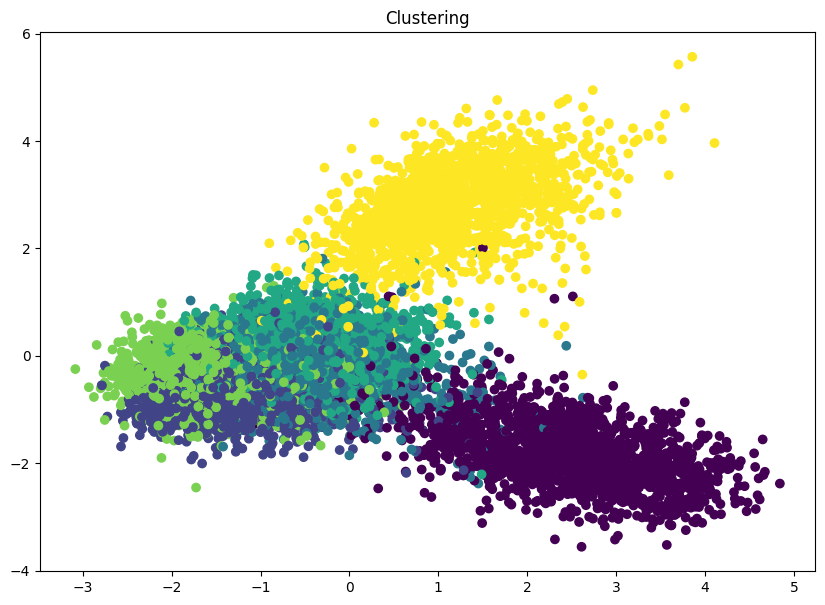

In [24]:
def apply_pca(vectors, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(vectors)

def plot_clusters(pca_result, labels, centers=None, title='Clustering'):
    plt.figure(figsize=(10, 7))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')

    if centers is not None:
        centers_pca = apply_pca(centers)
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='pink', marker='*')

    plt.title(title)
    plt.show()

pca_result = apply_pca(feature_vectors)
plot_clusters(pca_result, numeric_labels)

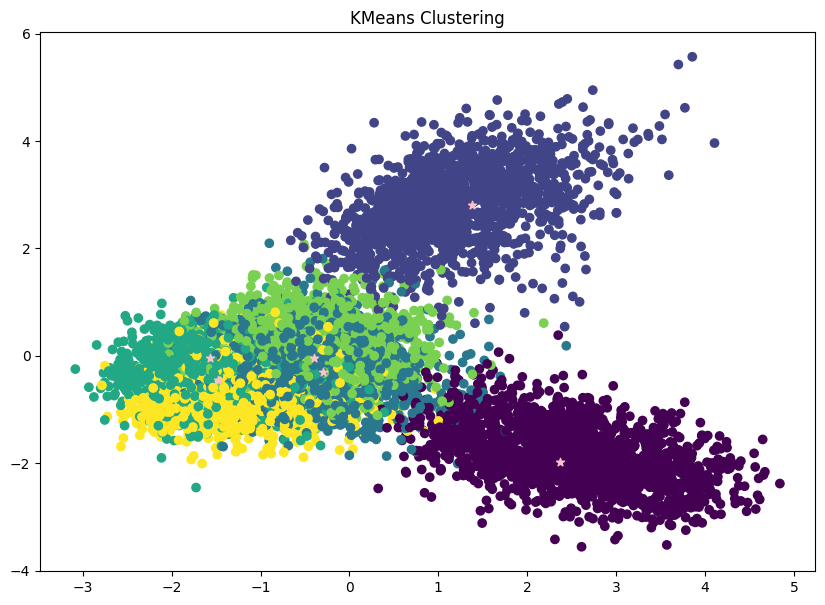

In [25]:
plot_clusters(pca_result, km_cluster_labels, km_word_cluster_centers, title='KMeans Clustering')

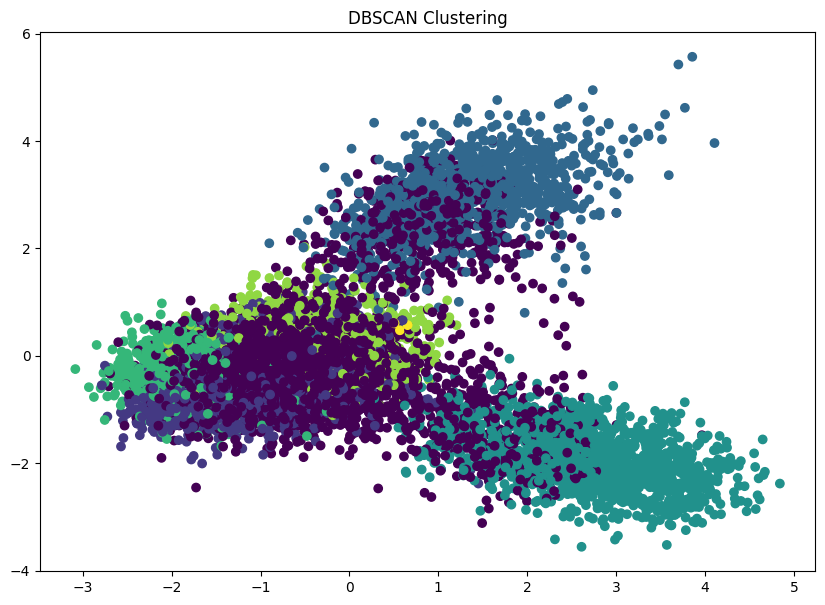

In [26]:
plot_clusters(pca_result, dbscan_labels, title='DBSCAN Clustering')

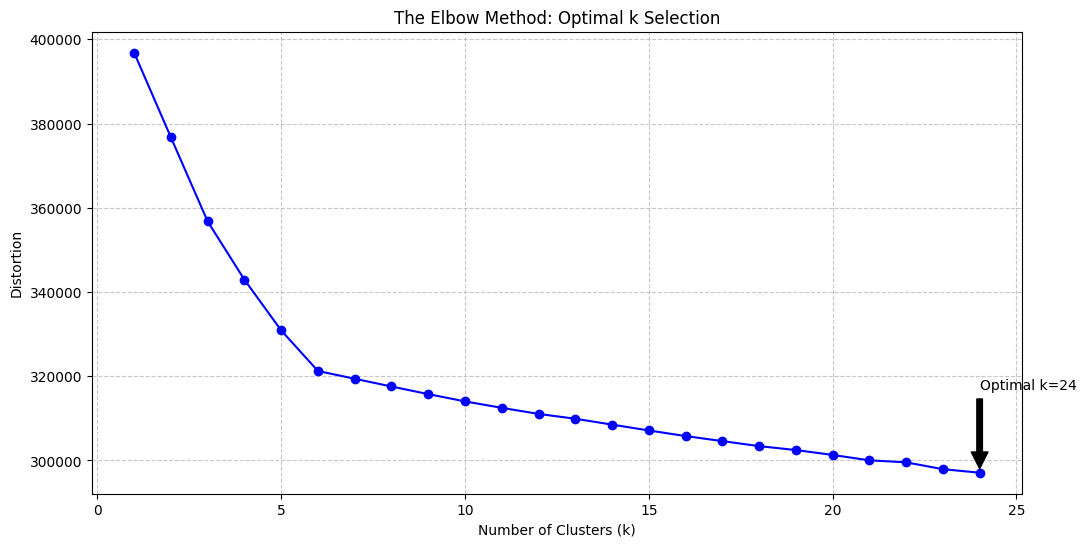

In [27]:
def calculate_distortions(vectors, k_range):
    distortions = []
    for k in k_range:
        kmeanModel = KMeans(
            n_clusters=k, 
            init='k-means++', 
            n_init=20, 
            max_iter=500, 
            random_state=1
        )
        kmeanModel.fit(vectors)
        distortions.append(kmeanModel.inertia_)
    return distortions

def plot_elbow_method(k_range, distortions):
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(k_range, distortions, marker='o', linestyle='-', color='b')
    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel('Distortion')
    ax.set_title('The Elbow Method: Optimal k Selection')
    ax.grid(True, linestyle='--', alpha=0.7)

    optimal_k_index = np.argmin(distortions)
    optimal_k = k_range[optimal_k_index]
    ax.annotate(
        f'Optimal k={optimal_k}', 
        xy=(optimal_k, distortions[optimal_k_index]),
        xytext=(optimal_k, distortions[optimal_k_index] + max(distortions) * 0.05),
        arrowprops=dict(facecolor='black', shrink=0.05),
    )

    plt.show()

K = range(1, 25)
distortions = calculate_distortions(feature_vectors, K)
plot_elbow_method(K, distortions)

***8.***
Explain about the calculation method of silhouette and homogeneity metrics.

These metrics commonly used to evaluate the performance of clustering algorithms.

**`Silhouette Score`**:<br>
how similar an object is to its own cluster compared to other clusters<br>
- Measures how well-separated clusters are.<br> 
- It takes into account both the **cohesion** within clusters and the **separation** between clusters.<br>
- For each data point, the silhouette score is calculated using the following formula:

$$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

$s(i)$ <small>the silhouette score for data point i.</small><br>
$a(i)$ <small>(`intra cluster distance`) is the average distance from the i-th point to other points in the same cluster.</small><br>
$b(i)$ <small>(`inter cluster distance`) is the smallest average distance from the ii-th point to points in a different cluster, minimized over clusters.</small><br>

- Ranges from -1 to 1:<br>
A `high` silhouette score : the object is well-matched to its own cluster and poorly matched to neighboring clusters.<br>
A `low` silhouette score : the object may be assigned to the wrong cluster.<br>

- The overall silhouette score for a clustering is the **average** of silhouette scores for all data points.

---

**`Homogeneity Score`**:<br>
 It measures the extent to which each cluster contains only data points that belong to a single class.<br>
- Measures the degree to which each cluster contains only members of a single class.<br>
- Based on the concept of entropy from information theory.<br>
- The homogeneity score is calculated using the following formula:

$$H(C, K) = 1 - \frac{H(C|K)}{H(C)}$$

where:

$H(C,K)$ <small>the homogeneity score.</small><br>
$H(C∣K)$ <small>the conditional entropy of the class labels given the cluster assignments.</small><br>
$H(C)$ <small>the entropy of the true class labels.</small><br>
<br>

- Ranges from 0 to 1:<br>
Higer score : Each cluster contains only members of a single class.<br>
Lower score : Clusters contain mixed class members.

---

***10.***
Suggest solutions to improve the performance of the models.

1. `Larger Dataset`: <br>
Our corpus does not seem to be sufficiently large, resulting in the doc2vec model’s inability to extract satisfactory features. To improve the performance of our model, it may be necessary to procure a larger training dataset.

2. `Algorithm Modification`: <br>
There are improved versions of these algorithms that can be considered. <br>
- K-DBSCAN, an improved DBSCAN algorithm, applies an initial grouping to the data through the K-means++ algorithm, then employs DBSCAN to perform clustering in each group separately.
 
3. `Feature Selection/Extraction`: <br>
Reducing the dimensionality of data with techniques such as PCA, can improve the speed and potentially the accuracy of models.

1. `Optimization Algorithms`: <br>
This improves the parameters of DBSCAN. For example, an efficient DBSCAN optimized by arithmetic optimization algorithm (OBLAOA-DBSCAN) can provide highly accurate clusters more efficiently.

1. `Using more Optimized Word feature extraction` 